# Yolo v5


Steps For Training Custom YOLOv5 Object Detector With Custom Dataset
- Environmental set up and Installation of YOLOv5 dependencies
- Preprocessing Custom Dataset
- Define YOLOv5 Model Configuration and Architecture
- Train a custom YOLOv5 Detector
- Evaluate YOLOv5 performance
- Visualize YOLOv5 training data
- Run YOLOv5 Inference on test images
- Export Saved YOLOv5 Weights for Future Inference


### Environmental set up and Installation of YOLOv5 dependencies

```
$ git clone https://github.com/ultralytics/yolov5 # clone repo

$ pip install -U -r yolov5/requirements.txt # install dependencies

$ cd /content/yolov5 #change directory into project folder.
```



Image Label for YOLOv5 was made using LabelImg 

Steps: 
1. Install LabelImg 
```
pip install labelimg
```
2. Open an image using LabelImg
```
labelimg <path-to-the-image> <path-to-class.txt-file>
```
In the classes.txt file you need to list all the classes in new line. 
for example: 

```
car 
bike
truck 
```



### Showing some dataset images

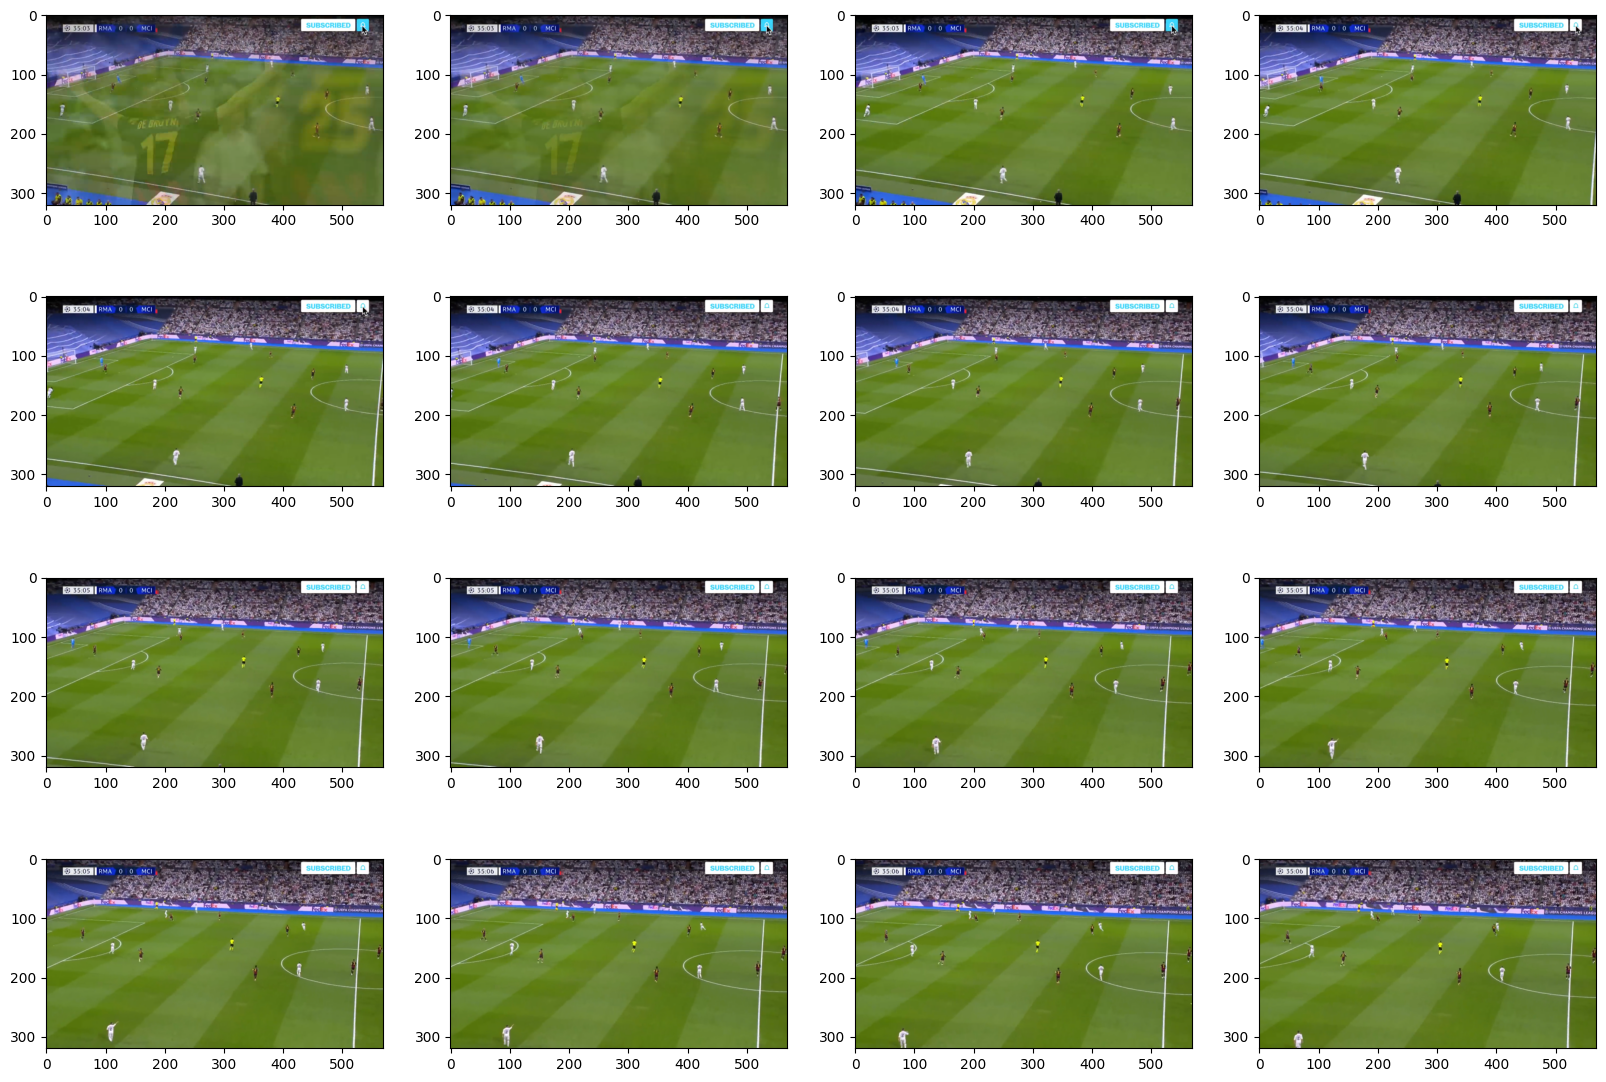

In [9]:
import matplotlib.pyplot as plt
import os
import cv2

# Use a raw string to avoid issues with backslashes
file_path = r"C:\Users\HP\Documents\py\Object Detection\dataset\Live match images"

imshow_dirs = []
dirs = os.listdir(file_path)

fig, ax = plt.subplots(4, 4, figsize=(20, 14))
for n in range(4):
    for m in range(4):
        path = os.path.join(file_path, dirs[m + 4*n])  # Properly join the file path
        image = plt.imread(path)  # Read the image using the correct file path
        ax[n, m].imshow(image)
        ax[n, m].grid(False)

plt.show()


### Changing annotation format to YOLO format

Depending on what you used to annotate the dataset with, you might have to convert the annotated format to YOLO format. 

Syntax for YOLO annotation format is as follows: 
```
<class> <x_center> <y_center> <width> <height>

```


If you use LabelImg to annotate the dataset your current annotation syntax is in Pascal VOC XML format, not .txt: 
```
<annotation>
    <folder>Images</folder>
    <filename>image1.jpg</filename>
    <path>/path/to/image1.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>800</width>
        <height>600</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>cat</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>100</xmin>
            <ymin>150</ymin>
            <xmax>400</xmax>
            <ymax>350</ymax>
        </bndbox>
    </object>
    <object>
        <name>dog</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>500</xmin>
            <ymin>200</ymin>
            <xmax>700</xmax>
            <ymax>400</ymax>
        </bndbox>
    </object>
</annotation>
```

You might have to convert this to YOLO format. 


In [14]:
# If you annotation is in Pascal VOC XML format 
# convert it to yolo format

import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
dirs = ['train', 'val']
classes = ['antenna']


def getImagesInDir(dir_path):
   image_list = []
   for filename in glob.glob(dir_path + '/*.jpg'):
       image_list.append(filename)
   return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]
    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    for obj in root.iter('object'):
       difficult = obj.find('difficult').text
       cls = obj.find('name').text
       if cls not in classes or int(difficult)==1:
           continue
       cls_id = classes.index(cls)
       xmlbox = obj.find('bndbox')
       
       b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),                         float(xmlbox.find('ymin').text),                  float(xmlbox.find('ymax').text))
       bb = convert((w,h), b)
       out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

cwd = getcwd()

for dir_path in dirs:
    full_dir_path = cwd + '/' + dir_path
    output_path = full_dir_path +'/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    image_paths = getImagesInDir(full_dir_path)
    list_file = open(full_dir_path + '.txt', 'w')
    for image_path in image_paths:
        list_file.write(image_path + '\n')                  
    convert_annotation(full_dir_path, output_path, image_path)
    list_file.close()

print("Finished processing: " + dir_path)

NameError: name 'image_path' is not defined

### Define YOLOv5 Model Configuration And Architecture

Before training you need to modify the YAML file which specifies the location or path of thetrainingfolder and validation folder, and also information on our the names and number of classes.

The .yaml file should be in yolov5(repo that you cloned)/data

```
#train and val datasets (image directory or *.txt file with image paths)
path: 
train: <path-to-train-images>
val: <path-to-val-images>

# Classes
names: 
    0: A
    1: B
    2: C

```

For this tutorial, we chose the smallest and fastest base model of YOLOv5 which is `yolov5s`. You have the option to pick any of the four YOLOv5 models which includes:

- yolov5-s
- yolov5-m
- yolov5-l
- yolov5-x


Next, you should download pretrained weights for transfer learning from Ultralytics. After downloading your prefered model, move the downloaded model weight into the weight folder that is in the root project folder.

Next, we need to modify the YAML configuration file of the corresponding version of YOLOv5 model that you just downloaded and choose to use for your training, from your YOLOv5 folder change directory to models folder and change number of class nc to 3.

In [18]:
# Downloading pretrained waights for transfer learning form Ultralytics. 
!cd C:\Users\HP\Documents\py\Object Detection\YOLO v5\yolov5
!python -c "from utils.google_utils import attempt_download; attempt_download('yolov5s.pt')"


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'utils'


This command will download the pre-trained weights file yolov5s.pt to the yolov5 directory.


### Freeze the YOLOv5 Backbone
The backbone means the layers that extract input image features. We will freeze the backbone so the weights in the backbone layers will not change during YOLOv5 transfer learning. We will only train the last layers (i.e., head layers). As we will use the smallest model (yolov5s), we need to find out which layers are the backbone. Let’s open `yolov5/models/yolov5s.yaml` to see the model structure:

```
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

```


Here you can see that there are 10 layers in the backbone. So we freeze the first 10 layers. 


### YOLOv5 transfer learning execution

In [33]:
!cd "C:\Users\HP\Documents\py\Object Detection\YOLO v5"
!python "yolov5/train.py" --data "yolov5/data/football-players.yaml" --weights yolov5s.pt --epochs 10 --batch 4 --freeze 10

train: weights=yolov5s.pt, cfg=, data=yolov5/data/football-players.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5\data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
fatal: cannot change to 'C:\Users\HP\Documents\py\Object': No such file or directory
YOLOv5  2024-5-29 Python-3.12.1 torch-2.3.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmu

We can also manually evaluate the model performance with the following command:


In [34]:
!cd "C:\Users\HP\Documents\py\Object Detection\YOLO v5"
!!python yolov5/val.py --data football-players.yaml --weights yolov5/runs/train/exp4/weights/best.pt

["\x1b\x1bval: \x1bdata=C:\\Users\\HP\\Documents\\py\\Object Detection\\YOLO v5\\yolov5\\data\\football-players.yaml, weights=['yolov5/runs/train/exp4/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5\\runs\\val, name=exp, exist_ok=False, half=False, dnn=False",
 "fatal: cannot change to 'C:\\Users\\HP\\Documents\\py\\Object': No such file or directory",
 'YOLOv5  2024-5-29 Python-3.12.1 torch-2.3.0+cpu CPU',
 '',
 'Fusing layers... ',
 'Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs',
 '',
 '\x1b\x1bval: \x1bScanning C:\\Users\\HP\\Documents\\py\\Object Detection\\dataset\\Annotated\\test\\labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]',
 '\x1b\x1bval: \x1bScanning C:\\Users\\HP\\Documents\\py\\Object Detection\\dat

In [41]:
!cd "C:\Users\HP\Documents\py\Object Detection\YOLO v5"
!python yolov5/detect.py --weights "C:\Users\HP\Documents\py\Object Detection\YOLO v5\yolov5\runs\train\exp6\weights\best.pt" --conf 0.25 --source "C:\Users\HP\Documents\py\Object Detection\YOLO v5\yolov5\runs\val\exp2\val_batch0_pred.jpg"

detect: weights=['C:\\Users\\HP\\Documents\\py\\Object Detection\\YOLO v5\\yolov5\\runs\\train\\exp6\\weights\\best.pt'], source=C:\Users\HP\Documents\py\Object Detection\YOLO v5\yolov5\runs\val\exp2\val_batch0_pred.jpg, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\HP\Documents\py\Object': No such file or directory
YOLOv5  2024-5-29 Python-3.12.1 torch-2.3.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 C:\Users\HP\Documents\py\Object Detection\YOLO v5\yolov5\runs\val\exp2\val_batch0_pred.jpg: 640x640 41 As, 1 B, 170.